<a href="https://colab.research.google.com/github/nashapir/Vision-Projects/blob/main/Shoe_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shoe generator: Pix2pix on edges2shoes dataset

We train the pix2pix model on the edges2shoes dataset [1, 2] to translate images containing only the edges of a shoe, to a full image of a shoe. The edges are automatically extracted from the real shoe images.

Credit for prompts and portions of code to EECS 442, University of Michigan



# Setup

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101
Using the GPU!


#pix2pix
We break down the pix2pix model construction into the following steps:

1. Contruct dataloaders for train/test datasets
2. Build Generator and Discriminator
3. Train pix2pix and visualize the results during training
4. Plot the loss of generator/discriminator v.s. iteration
5. Design your own shoes

## Step 0: Downloading the dataset.

We first download the `mini-edges2shoes` dataset sampled from the original `edges2shoes` dataset. The `mini-edges2shoes` dataset contains 1,000 training image pairs, and 100 testing image pairs.

In [ ]:
# Download the mini-edges2shoes dataset
!rm -r mini-edges2shoes.zip
!rm -r mini-edges2shoes
!wget http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
!unzip -q mini-edges2shoes.zip

rm: cannot remove 'mini-edges2shoes.zip': No such file or directory
rm: cannot remove 'mini-edges2shoes': No such file or directory
--2020-10-21 23:27:11--  http://www.eecs.umich.edu/courses/eecs442-ahowens/mini-edges2shoes.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48660290 (46M) [application/zip]
Saving to: ‘mini-edges2shoes.zip’

mini-edges2shoes.zi 100%[===================>]  46.41M  10.8MB/s    in 4.6s    

2020-10-21 23:27:16 (10.2 MB/s) - ‘mini-edges2shoes.zip’ saved [48660290/48660290]



## Step 1: Build dataloaders for train and test

We will first build dataloaders with PyTorch built-in classes. 

In [ ]:
class Edges2Shoes(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: the directory of the dataset
            split: "train" or "val"
            transform: pytorch transformations.
        """
        self.transform = transform
        self.files = glob.glob("*/" + split + "/*")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img = np.asarray(img)
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

tr_dt = Edges2Shoes("./mini-edges2shoes/", transform=transform)
te_dt = Edges2Shoes("./mini-edges2shoes/", split="val", transform=transform)

train_loader = DataLoader(tr_dt, batch_size=4, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=5, shuffle=False)
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1000, number of testing images 100


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


250
20
torch.Size([5, 3, 256, 256])


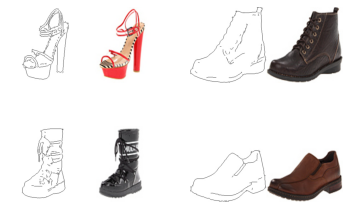

In [ ]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
img_size = 256
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
    example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    example = std * example + mean
    axes[i].imshow(example)
    axes[i].axis('off')
plt.show()

## Step 2: Build Generator and Discriminator
Based on the paper, the architectures of network are as following:

**Generator architectures:**

U-net encoder:

C64-C128-C256-C512-C512-C512-C512-C512

U-net decoder:

C512-C512-C512-C512-C256-C128-C64-C3

After the last layer in the decoder, a convolution is applied to map to the number of output channels, followed by a Tanh
function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder.
All ReLUs in the encoder are leaky, with slope 0.2, while
ReLUs in the decoder are not leaky.

**Discriminator architectures**

The discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

In [ ]:
def normal_init(m, mean, std):
    """
    Helper function. Initialize model parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [ ]:
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        # Define function
        def convrelu(in_channels, out_channels):
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
              nn.BatchNorm2d(out_channels),
              nn.LeakyReLU(negative_slope=0.2)
          )

        def convrelu_decode(in_channels, out_channels):
          return nn.Sequential(
              nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
              nn.BatchNorm2d(out_channels),
              nn.ReLU()
          )

        # Implement the first layer manually because there's no batch_norm
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.2)
        )
        # Implement rest of the layers using function
        self.layer2 = convrelu(64, 128)
        self.layer3 = convrelu(128, 256)
        self.layer4 = convrelu(256, 512)
        self.layer5 = convrelu(512, 512)
        self.layer6 = convrelu(512, 512)
        self.layer7 = convrelu(512, 512)
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Implement decoder layers
        self.layer9 = convrelu_decode(512, 512)
        self.layer10 = convrelu_decode(1024, 512)
        self.layer11 = convrelu_decode(1024, 512)
        self.layer12 = convrelu_decode(1024, 512)
        self.layer13 = convrelu_decode(1024, 256)
        self.layer14 = convrelu_decode(512, 128)
        self.layer15 = convrelu_decode(256, 64)
        self.layer16 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        
        # Encoder Steps...
        layer1 = self.layer1(input)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)
        layer7 = self.layer7(layer6)
        layer8 = self.layer8(layer7)
        
        # Decoder Steps...
        
        layer9 = torch.cat((self.layer9(layer8), layer7), 1)
        layer10 = torch.cat((self.layer10(layer9), layer6), 1)
        layer11 = torch.cat((self.layer11(layer10), layer5), 1)
        layer12 = torch.cat((self.layer12(layer11), layer4), 1)
        layer13 = torch.cat((self.layer13(layer12), layer3), 1)
        layer14 = torch.cat((self.layer14(layer13), layer2), 1)
        layer15 = torch.cat((self.layer15(layer14), layer1), 1)
        o = self.layer16(layer15)

        return o

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)))
        layers.append(nn.LeakyReLU(negative_slope=0.2))
        layers.append(nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.LeakyReLU(negative_slope=0.2))
        layers.append(nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)))
        layers.append(nn.BatchNorm2d(256))
        layers.append(nn.LeakyReLU(negative_slope=0.2))
        layers.append(nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)))
        layers.append(nn.BatchNorm2d(512))
        layers.append(nn.LeakyReLU(negative_slope=0.2))
        layers.append(nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)))
        layers.append(nn.Sigmoid())
        self.classifier = nn.Sequential(*layers)


    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = self.classifier(input)

        return x

In [ ]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51



### generator architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 512, 1, 1]       4,194,816
    ConvTranspose2d-15            [-1, 512, 2, 2]       4,194,816
        BatchNorm2d-16            [-1, 512, 2, 2]           1,024
    ConvTranspose2d-17            [-1, 512, 4, 4]       8,389,120
        BatchNorm2d-18            [-1, 512, 4, 4]           1,024
    ConvTranspose2d-19            [-1, 512, 8, 8]       8,389,120
        BatchNorm2d-20            [-1, 512, 8, 8]           1,024
    ConvTranspose2d-21          [-1, 512, 16, 16]       8,389,120
        BatchNorm2d-22          [-1, 512, 16, 16]           1,024
    ConvTranspose2d-23          [-1, 256, 32, 32]       4,194,560
        BatchNorm2d-24          [-1, 256, 32, 32]             512
    ConvTranspose2d-25          [-1, 128, 64, 64]       1,048,704
        BatchNorm2d-26          [-1, 128, 64, 64]             256
    ConvTranspose2d-27         [-1, 64, 128, 128]         262,208
        BatchNorm2d-28         [-1, 64, 128, 128]             128
    ConvTranspose2d-29          [-1, 3, 256, 256]           6,147
----------------------------------------------------------------
    Total params: 54,419,459
    Trainable params: 54,419,459
    Non-trainable params: 0
----------------------------------------------------------------


### discriminator architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
----------------------------------------------------------------
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 1, 30, 30]           8,193
----------------------------------------------------------------
    Total params: 2,769,601
    Trainable params: 2,769,601
    Non-trainable params: 0
----------------------------------------------------------------


## Step 3: Train

We train two models: one with only L1 loss, the other with c=100.



In [ ]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 2].get_xaxis().set_visible(False)
        ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
        ax[i, 2].cla()
        ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [ ]:
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
    hist_D_losses = []
    hist_G_losses = []

    G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0
        for x_ in train_loader:

            y_ = x_[:, :, :, img_size:]
            x_ = x_[:, :, :, 0:img_size]
            
            x_, y_ = x_.cuda(), y_.cuda()

            D.zero_grad()

            # Real image
            real_input = torch.cat([x_, y_], 1)
            real_output = D(real_input).squeeze()

            # Fake image
            fake_g_output = G(x_)
            fake_input = torch.cat([x_, fake_g_output], 1)
            fake_output = D(fake_input).squeeze()

            # Train on average loss
            D_train_loss = (BCE_loss(fake_output, torch.zeros(fake_output.size()).cuda()) + BCE_loss(real_output, torch.ones(real_output.size()).cuda())) / 2.0
            D_train_loss.backward()
            D_optimizer.step()
            loss_D = D_train_loss.detach().item()

            # Train the generator
            G.zero_grad()

            G_result = G(x_)
            D_input = torch.cat([x_, G_result], 1)
            D_result = D(D_input).squeeze()

            if only_L1:
                G_train_loss = L1_loss(G_result, y_)
            else:
                G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
            
            G_train_loss.backward()
            G_optimizer.step()
            loss_G = G_train_loss.detach().item()

            D_losses.append(loss_D)
            hist_D_losses.append(loss_D)
            G_losses.append(loss_G)
            hist_G_losses.append(loss_G)
            num_iter += 1

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        if epoch == 0 or (epoch + 1) % 5 == 0:
            with torch.no_grad():
                show_result(G, fixed_x_, fixed_y_, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses

In this part, we train our model with c=100 with at leat 20 epoch.

In [ ]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (classifier): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

training start!
Start training epoch 1
[1/20] - using time: 63.88 seconds
loss of discriminator D: 0.473
loss of generator G: 30.878


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


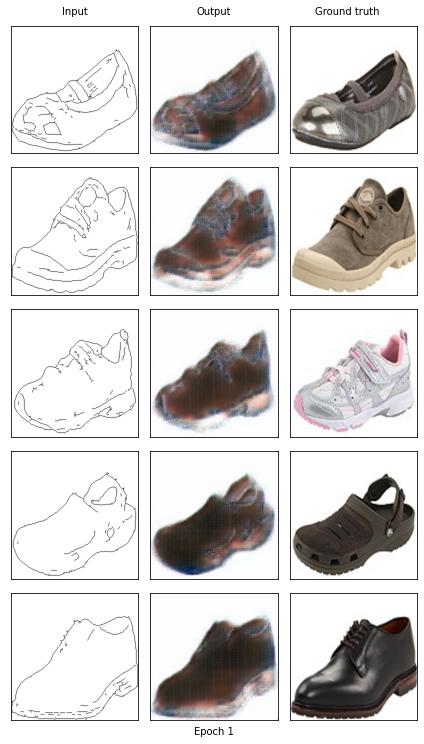

Start training epoch 2
[2/20] - using time: 66.80 seconds
loss of discriminator D: 0.439
loss of generator G: 24.085
Start training epoch 3
[3/20] - using time: 66.93 seconds
loss of discriminator D: 0.467
loss of generator G: 22.436
Start training epoch 4
[4/20] - using time: 67.03 seconds
loss of discriminator D: 0.468
loss of generator G: 21.472
Start training epoch 5
[5/20] - using time: 67.08 seconds
loss of discriminator D: 0.442
loss of generator G: 20.220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


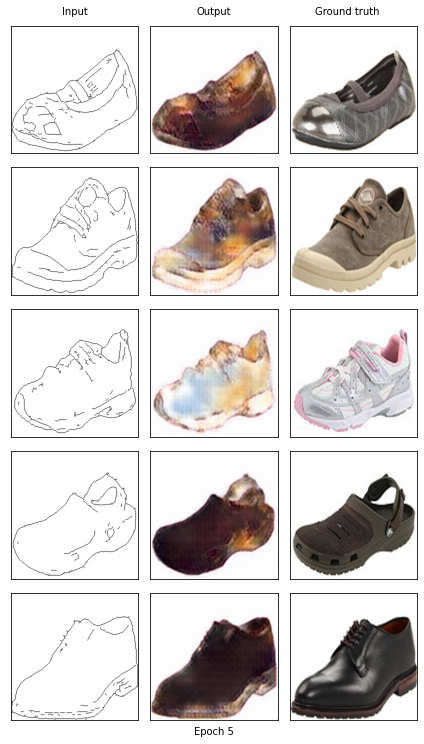

Start training epoch 6
[6/20] - using time: 67.05 seconds
loss of discriminator D: 0.295
loss of generator G: 20.280
Start training epoch 7
[7/20] - using time: 67.06 seconds
loss of discriminator D: 0.048
loss of generator G: 21.425
Start training epoch 8
[8/20] - using time: 67.02 seconds
loss of discriminator D: 0.012
loss of generator G: 22.109
Start training epoch 9
[9/20] - using time: 67.13 seconds
loss of discriminator D: 0.053
loss of generator G: 20.399
Start training epoch 10
[10/20] - using time: 67.19 seconds
loss of discriminator D: 0.108
loss of generator G: 19.353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


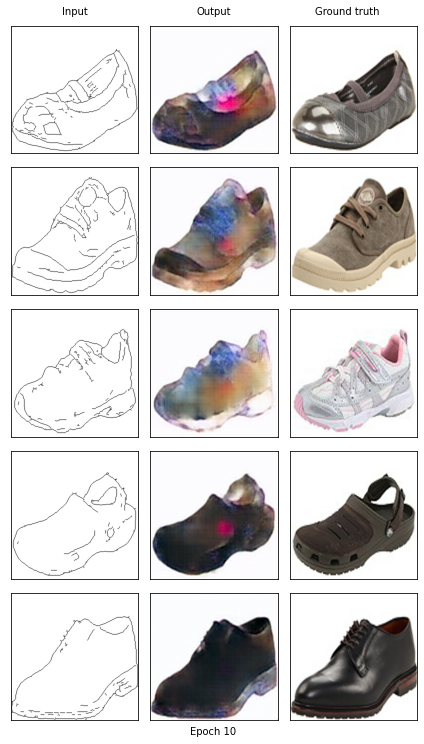

Start training epoch 11
[11/20] - using time: 67.11 seconds
loss of discriminator D: 0.005
loss of generator G: 20.237
Start training epoch 12
[12/20] - using time: 67.14 seconds
loss of discriminator D: 0.390
loss of generator G: 16.147
Start training epoch 13
[13/20] - using time: 67.13 seconds
loss of discriminator D: 0.086
loss of generator G: 17.775
Start training epoch 14
[14/20] - using time: 67.12 seconds
loss of discriminator D: 0.002
loss of generator G: 19.173
Start training epoch 15
[15/20] - using time: 67.14 seconds
loss of discriminator D: 0.001
loss of generator G: 19.542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


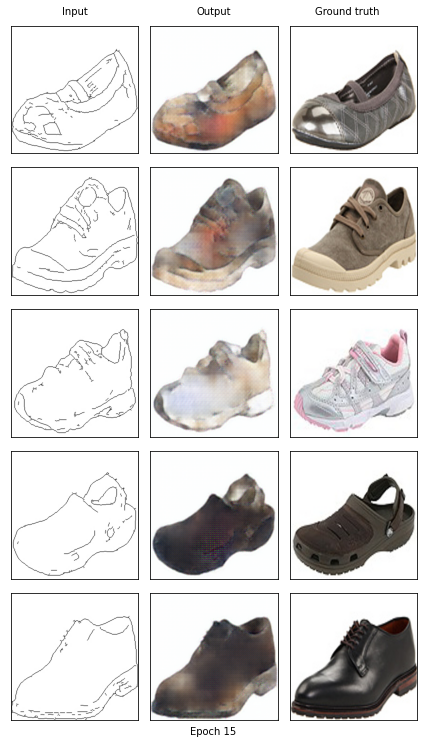

Start training epoch 16
[16/20] - using time: 67.19 seconds
loss of discriminator D: 0.160
loss of generator G: 17.497
Start training epoch 17
[17/20] - using time: 67.19 seconds
loss of discriminator D: 0.054
loss of generator G: 16.301
Start training epoch 18
[18/20] - using time: 67.16 seconds
loss of discriminator D: 0.003
loss of generator G: 17.401
Start training epoch 19
[19/20] - using time: 67.16 seconds
loss of discriminator D: 0.201
loss of generator G: 15.745
Start training epoch 20
[20/20] - using time: 67.10 seconds
loss of discriminator D: 0.514
loss of generator G: 11.275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


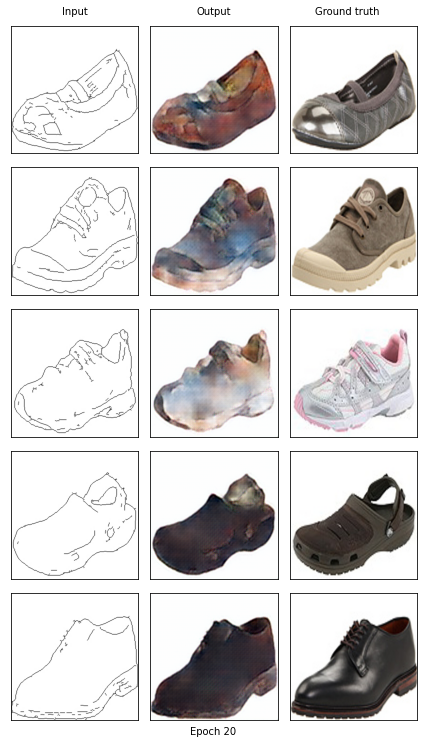

In [ ]:
# training
hist_D_100_losses, hist_G_100_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [ ]:
!mkdir models
torch.save(G_100.state_dict(), './models/G_100.pth')
torch.save(D_100.state_dict(), './models/D_100.pth')

Now, we train our model with only L1 loss with at leat 10 epoch.

training start!
Start training epoch 1
[1/10] - using time: 62.45 seconds
loss of discriminator D: 0.281
loss of generator G: 0.281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


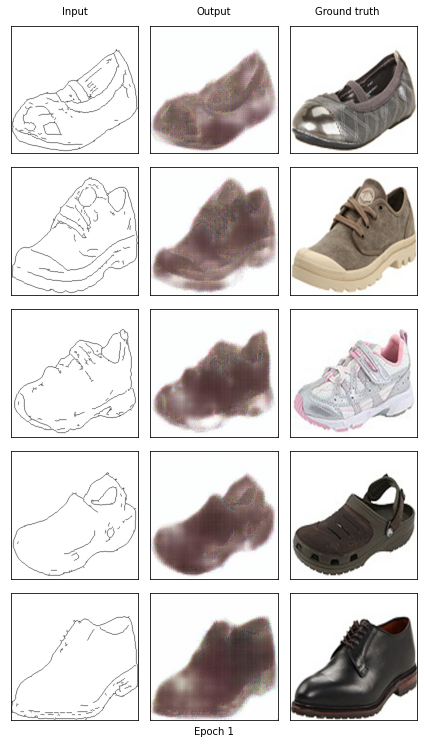

Start training epoch 2
[2/10] - using time: 62.40 seconds
loss of discriminator D: 0.194
loss of generator G: 0.214
Start training epoch 3
[3/10] - using time: 62.36 seconds
loss of discriminator D: 0.133
loss of generator G: 0.198
Start training epoch 4
[4/10] - using time: 61.26 seconds
loss of discriminator D: 0.004
loss of generator G: 0.188
Start training epoch 5
[5/10] - using time: 60.93 seconds
loss of discriminator D: 0.385
loss of generator G: 0.178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


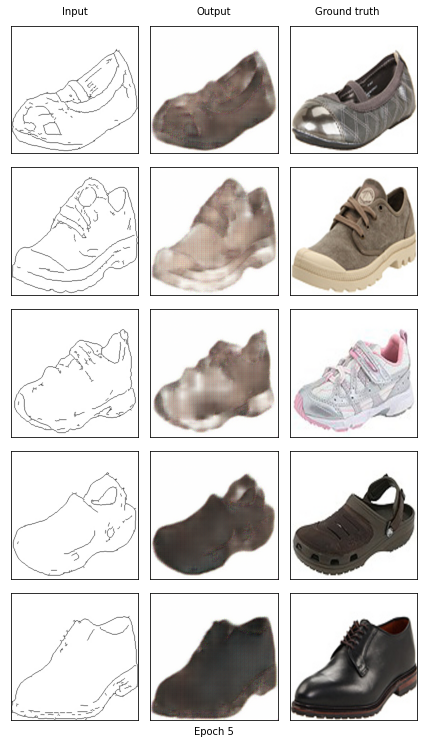

Start training epoch 6
[6/10] - using time: 62.12 seconds
loss of discriminator D: 0.244
loss of generator G: 0.167
Start training epoch 7
[7/10] - using time: 62.13 seconds
loss of discriminator D: 0.098
loss of generator G: 0.157
Start training epoch 8
[8/10] - using time: 62.17 seconds
loss of discriminator D: 0.039
loss of generator G: 0.152
Start training epoch 9
[9/10] - using time: 62.19 seconds
loss of discriminator D: 0.035
loss of generator G: 0.141
Start training epoch 10
[10/10] - using time: 62.17 seconds
loss of discriminator D: 0.022
loss of generator G: 0.136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


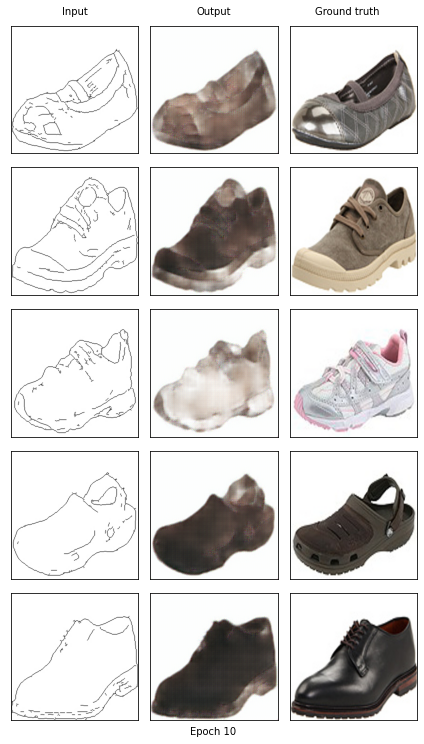

In [ ]:
# Define network
G_L1 = generator()
D_L1 = discriminator()
G_L1.weight_init(mean=0.0, std=0.02)
D_L1.weight_init(mean=0.0, std=0.02)
G_L1.cuda()
D_L1.cuda()
G_L1.train()
D_L1.train()

#training
hist_D_L1_losses, hist_G_L1_losses = train(G_L1, D_L1, num_epochs = 10, only_L1 = True)

### Note:

It looks like the quality of the imaged generated from L1+cGAN are significantly higher than those generated using L1 only. In particular, the colors appear more vivid and realistic -- there are more colors and they appear more convincing in the L1+cGAN (whereas the color distribution for the L1 only model is more limited). 

In [ ]:
torch.save(G_L1.state_dict(), './models/G_L1.pth')
torch.save(D_L1.state_dict(), './models/D_L1.pth')

In [ ]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/G_100.pth (deflated 7%)
  adding: models/D_100.pth (deflated 8%)
  adding: models/D_L1.pth (deflated 8%)
  adding: models/G_L1.pth (deflated 7%)


## Step 4: Vizualisation



In this section, plot the G/D loss history v.s. Iteration of models with c=100 seperate plots.

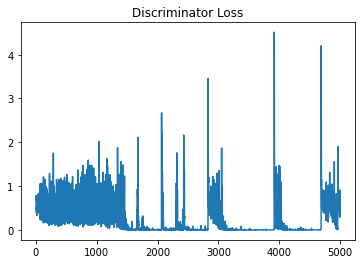

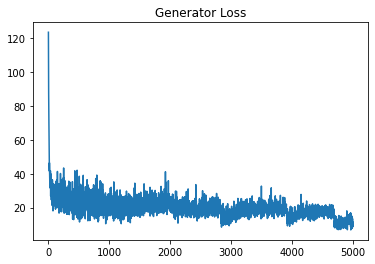

In [ ]:
# plot the G/D loss history v.s. Iteration
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(hist_D_100_losses)
plt.title('Discriminator Loss')
plt.show()

plt.figure()
plt.plot(hist_G_100_losses)
plt.title('Generator Loss')
plt.show()



In this section, plot the G/D loss history v.s. Iteration of model with only L1 loss in seperate plots.

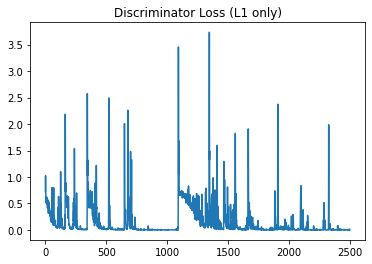

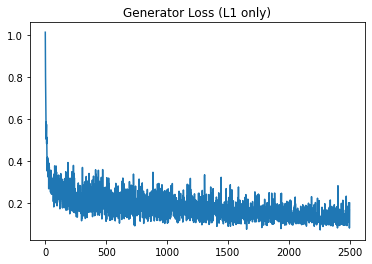

In [ ]:
# plot the G/D loss history v.s. Iteration in one plot
plt.figure()
plt.plot(hist_D_L1_losses)
plt.title('Discriminator Loss (L1 only)')
plt.show()

plt.figure()
plt.plot(hist_G_L1_losses)
plt.title('Generator Loss (L1 only)')
plt.show()

## Step 5: Design Your Shoes

Now we can sketch our dream shoes and let the trained model generate them for us!

In [ ]:
# Build a panel that allows sketching in Colab
# Source: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
    print('Please sketch below.')
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return len(binary)

!mkdir mini-edges2shoes/custom
!apt-get --quiet install imagemagick

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsf

In [ ]:
draw(w=256, h=256)
!convert drawing.png drawing.jpg

# save the drawing to dataset folder as a jpg image
img = np.asarray(Image.open('drawing.png'))
img = 255 - img
image.imsave('./mini-edges2shoes/custom/drawing.jpg', np.repeat(img[:,:,3:], 3, axis=2))

custom_dt = Edges2Shoes('./mini-edges2shoes', 'custom', transform)
custom_loader = DataLoader(custom_dt, batch_size=1, shuffle=False)

Please sketch below.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


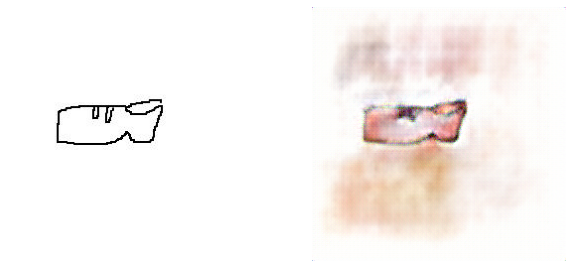

In [ ]:
# Optional: for loading saved generator
G_100 = generator().cuda()
G_100.load_state_dict(torch.load('./models/G_100.pth'))
G_100.eval()

# process the sketch
for x_ in custom_loader:
    x_ = x_.cuda()[:,:,:,:img_size]
    y_ = G_100(x_)

# visualize the image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
img_ = process_image(y_[0])
img = process_image(x_[0])
axis[0].imshow(img)
axis[0].axis('off')
axis[1].imshow(img_)
axis[1].axis('off')
plt.show()